# E-SEIC
Selection of evolutionary instances with constraints for unbalanced datasets

In [1]:
from utils.dataset_utils import get_distribution, k_fold_cross_validation
from instance_selection.parameter.parameter import *  # 导入参数的设定
from instance_selection.operator.init_toolbox import init_toolbox_eseic
from instance_selection.operator.metrics import calculate_gmean_mauc, calculate_average_accuracy, \
    calculate_average_gmean_mauc, calculate_accuracy
from instance_selection.operator.genetic_operator import selTournamentNDCD
from instance_selection.operator.ensemble import vote_result_ensembles, ensemble_individuals
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import scipy.io as sio  # 从.mat文件中读取数据集
import random
from deap import tools
import warnings
import numpy as np

warnings.filterwarnings("ignore")  # 忽略警告
DATASET = Contraceptive  # 数据集名称（包含对应参数的字典形式）
datasetname = DATASET['DATASETNAME'].split('.')[0]
mat_data = sio.loadmat('../../data/dataset/' + DATASET['DATASETNAME'])  # 加载、划分数据集
x = mat_data['X']
y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)  # 划分数据集
scaler = StandardScaler()  # 数据的标准化
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

unique_elements_all, classes_all, counts_all = get_distribution(y)  # 获取原始数据集分布
unique_elements_train, classes_train, counts_train = get_distribution(y_train)  # 获取训练集分布
unique_elements_test, classes_test, counts_test = get_distribution(y_test)  # 获取测试集分布
print(datasetname + f' distribution: {counts_all}')
print(f'trainset distribution: {counts_train}')
print(f'testset distribution: {counts_test}')

model = MLPClassifier(hidden_layer_sizes=(DATASET['HIDDEN_SIZE'],), max_iter=DATASET['MAX_ITER'],
                      random_state=RANDOM_SEED, learning_rate_init=DATASET['LEARNING_RATE'])

weights_train = (1 / counts_train.astype(float)) / np.sum(1 / counts_train.astype(float))  # 计算每个类的权重，用于计算每个类别的权重
weights_test = (1 / counts_test.astype(float)) / np.sum(1 / counts_test.astype(float))  # 计算每个类的权重，用于计算每个类别的权重

num_instances = int(np.ceil(counts_train.min() * 0.9))  # 取最小数量的类的0.9（向下取整）
print("最小数量:", num_instances)

y_train_pred_proba = k_fold_cross_validation(model=clone(model), X=x_train, y=y_train, n_splits=N_SPLITS, method='soft',
                                             random_state=RANDOM_SEED)  # 交叉验证得到软标签
# 将概率转化为预测结果
y_train_pred = np.argmax(y_train_pred_proba, axis=1)

Acc1, Acc2, Acc3 = calculate_accuracy(y_train_pred, y_train, weights_train)
constraints = [Acc1, Acc2, Acc3]

Contraceptive distribution: [629 333 511]
trainset distribution: [499 262 417]
testset distribution: [130  71  94]
最小数量: 236


## E-SEIC

In [2]:
toolbox = init_toolbox_eseic(model, x_train, y_train, weights_train, constraints, n_splits=N_SPLITS,
                             random_seed=RANDOM_SEED)  # 初始化toolbox


def main(x_train, y_train, model, balanced_method='balanced'):
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "feasible", "ensembles_size", "avg_gmean", "avg_mauc", "avg_acc2"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)  # 个体编码默认全为0
    pop = toolbox.init_population(pop, balanced_method=balanced_method)  # 初始化种群中的个体
    toolbox.evaluate(pop)  # 计算个体的适应度
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        offspring = selTournamentNDCD(pop, POPSIZE, tournsize=3)  # 锦标赛选择（1、先根据非支配排序的等级2、再根据拥挤距离）
        offspring = [toolbox.clone(ind) for ind in offspring]
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])  # 单点交叉
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]  # 二进制反转突变
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]  # 二进制反转突变
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        #############################################################合并、去重#####################################################
        pop = pop + offspring  # 种群的合并
        pop, _ = toolbox.remove_duplicates(pop)  # 去重
        while len(pop) < POPSIZE:  # 保证种群大小为POPSIZE
            add_individual = []
            num_add = POPSIZE - len(pop)
            for i in range(0, num_add):
                index = random.randint(0, len(offspring) - 1)  # 在0-len(offspring)范围内随机产生一个索引
                offspring[index] = toolbox.mutate(offspring[index], MR)[0]  # 选择index对应的个体进行突变
                del offspring[index].fitness.values
                add_individual.append(offspring[index])
            pop = pop + add_individual  # 种群的合并
            pop, _ = toolbox.remove_duplicates(pop)  # 去重
        toolbox.evaluate(pop)  # 计算新种群适应度
        ###############################################得到pareto_fronts############################################
        feasible_pop, infeasible_pop = toolbox.get_feasible_infeasible(pop)  # 得到可行解与不可行解
        if len(feasible_pop) >= POPSIZE:
            pop, pareto_fronts = toolbox.select(feasible_pop, POPSIZE)
            ensembles = pareto_fronts[0]  # pareto_first_front
        elif len(feasible_pop) > 0:
            pop = feasible_pop + infeasible_pop[:POPSIZE - len(feasible_pop)]  # 在不可行解中选取违约程度小的个体，保证pop数量为POPSIZE
            ensembles = tools.sortNondominated(feasible_pop, len(feasible_pop))[0]  # pareto_first_front
        else:
            pop = feasible_pop + infeasible_pop[:POPSIZE - len(feasible_pop)]  # 加入不可行解中违约程度小的个体，保证pop数量为POPSIZE
            ensembles = [infeasible_pop[0]]  # 没有可行解，集成不可行解中第一个个体
        avg_gmean, avg_mauc = calculate_average_gmean_mauc(ensembles)  # 计算gmean、mauc的平均值
        _, avg_acc2, _ = calculate_average_accuracy(ensembles)  # 计算acc1、acc2、acc3的平均值

        record = stats.compile(pop)
        logbook.record(gen=gen, feasible=len(feasible_pop), ensembles_size=len(ensembles), avg_gmean=avg_gmean,
                       avg_mauc=avg_mauc, avg_acc2=avg_acc2, **record)
        # print(logbook.stream)
    ensemble_classifiers = ensemble_individuals(ensembles, model, x_train, y_train)
    return ensemble_classifiers


if __name__ == "__main__":
    print("*****************算法开始执行：******************")
    num_run = 3  # 运行次数
    ensembles_results = [[] for _ in range(num_run)]
    for i in range(num_run):
        ensemble_classifiers = main(x_train, y_train, model=model)
        vote_pred_prob = vote_result_ensembles(ensemble_classifiers, x_test)  # 默认预测结果是软标签
        vote_pred = np.argmax(vote_pred_prob, axis=1)
        gmean, mauc, recall_per_class = calculate_gmean_mauc(vote_pred_prob, y_test)
        acc1, acc2, acc3 = calculate_accuracy(vote_pred, y_test, weights_test)
        ensembles_results[i] = [gmean, mauc, acc1, acc2, acc3]
        print(f"第{i + 1}次执行：Gmean：{gmean}，mAUC：{mauc}，Acc1：{acc1}，Acc2：{acc2}，Acc3：{acc3}")
    print("*****************算法执行结束！******************")
    ensembles_result_mean = np.mean(ensembles_results, axis=0)
    print(f'集成分类结果（平均值）：{ensembles_result_mean}')

*****************算法开始执行：******************
gen	feasible	ensembles_size	avg_gmean	avg_mauc	avg_acc2
1  	3       	1             	0.562876 	0.716296	0.564993
2  	4       	1             	0.562876 	0.716296	0.564993
3  	6       	1             	0.562876 	0.716296	0.564993
4  	8       	1             	0.562876 	0.716296	0.564993
5  	12      	1             	0.562876 	0.716296	0.564993
6  	18      	1             	0.562876 	0.716296	0.564993
7  	21      	1             	0.562876 	0.716296	0.564993
8  	28      	1             	0.562876 	0.716296	0.564993
9  	36      	2             	0.558952 	0.723693	0.561561
10 	43      	2             	0.558952 	0.723693	0.561561
11 	49      	2             	0.563276 	0.727327	0.566384
12 	48      	2             	0.563276 	0.727327	0.566384
13 	51      	1             	0.579096 	0.74154 	0.583173
14 	52      	1             	0.579096 	0.74154 	0.583173
15 	49      	1             	0.579096 	0.74154 	0.583173
16 	47      	1             	0.579096 	0.74154 	0.583173
17 	4

## 绘制结果曲线

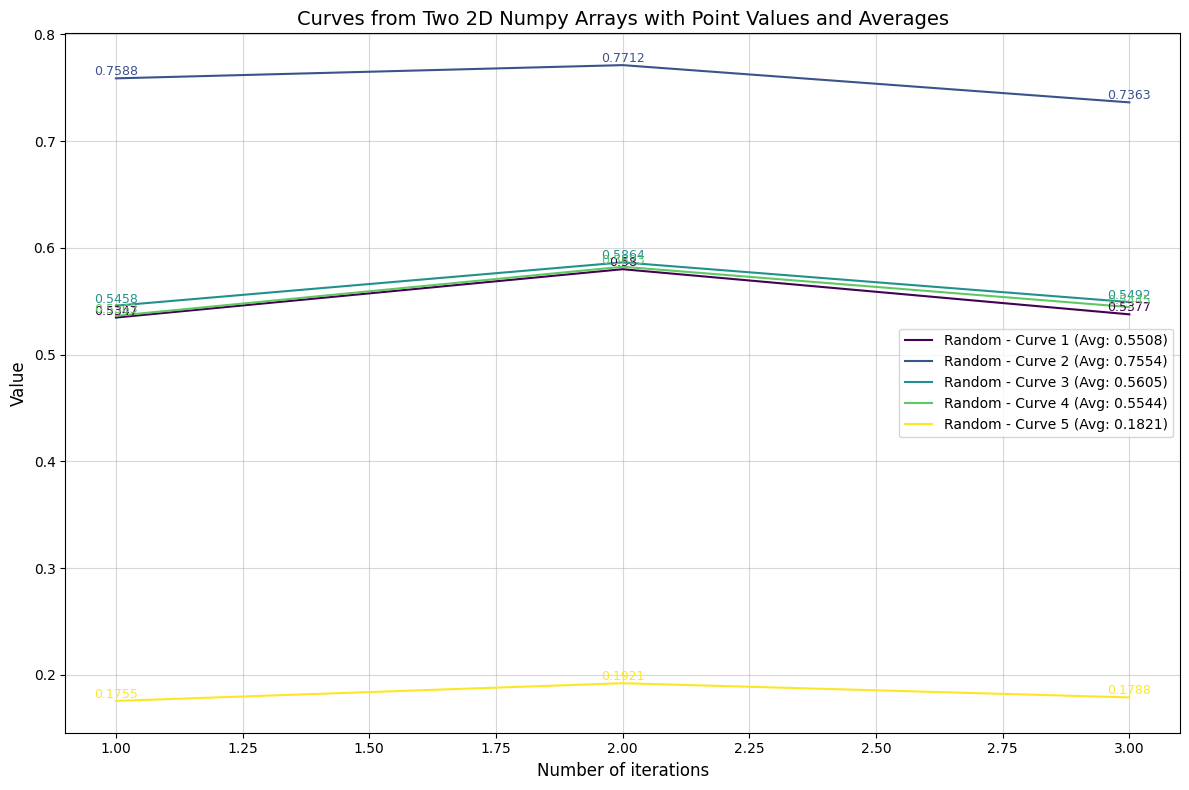

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Example data
data1 = np.round(np.array(ensembles_results).T, 4)

datasets = [data1]
colors1 = plt.cm.viridis(np.linspace(0, 1, len(data1)))

plt.figure(figsize=(12, 8))

# Plot Dataset 1
for i, (curve, color) in enumerate(zip(data1, colors1)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, label=f'Random - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot settings
plt.title('Curves from Two 2D Numpy Arrays with Point Values and Averages', fontsize=14)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

save_path = 'C:\\Users\\zsc\\Desktop\\evolution computation\\meeting\\2025.1.8\\e-mosaic\\' + datasetname + '\\'
# 创建文件夹（如果不存在）
folder = os.path.dirname(save_path)
if not os.path.exists(folder):
    os.makedirs(folder)
# Show plot
plt.savefig(save_path + datasetname + f'ensemble_gmean_mauc.jpg', dpi=300, bbox_inches='tight')